# Refrigeration System Analysis

This  analyis estimates the fuel savings that could be achieved by upgrading the refrigeration system on board F/V Eigil B. The calculation has three parts: first, parameters of the refrigeration systems are determined. Second, the fuel consumption rate of the generators is calculated as a function of load. Finally, the annual fuel consumption due to refrigeration is calculated based on the generator fuel consumption curves and the refrigeration load.

The analysis uses a simple model of new systems. The model includes a compressor (or two), two circulation pumps with vfd control, a condenser pump, a compressor cooling pump and a general term for system efficiency. A VFD on the compressor is not included, because it was found to have little value. The performance of the new compressors was looked up at a range of saturated suction temperatures and the data were used to estimate pump-down time.

The model of the old system uses the same components, but without any VFD control on the circulating pumps. Because I haven't been able to find performance data for the old compressor, its assumed to run at constant power rather than a power dependent on operating conditions.

The analysis is conducted in a Jupyter Notebook. A Jupyter Notebook allows text, figures and computer code to be presented in one document. Here, text is presented in black font fully left justified, while computer code (Python in this case) is presented a color-coded font and indented. Variables are defined and calculations are performed in the computer code "cells," while explanations are presented in the text "cells."

In [1]:
# This bit of code imports some software that the analysis uses and defines some constants
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline
water_heat_cap = 8.35 # btu/gal-F
joule_per_btu = 1055 
sec_per_hr = 3600
watt_per_kW = 1000

## Freezer load

### General cooling conditions
This section defines variables that are consistent for all of the proposed systems. "system_eff" (defined as 0.8 below) is used to estimate the system COP based on the compressor COP. I chose this number arbitrarily, because I don't have an idea of how to estimate based on the data available.

The effect of the VFD on the circulating pumps is defined by the circ_vfd_ratio variable. The analysis assumes that circ pumps run at full speed (60 Hz) when filling the tanks, and 1/2 speed (30 Hz) at all other times.

In [2]:
system_eff = 0.8 # Assumed system efficiency outside of the compressor

In [39]:
sea_temp = 59
target_temp = 33
aft_tank_capacity = 19448 # gallons
forward_tank_capacity = 14960 # gallons
n_aft_tank_pulldown = 33 # pulldowns per year
n_all_tank_pulldown = 1 # pulldowns per year
lbs_fish_cooled = 1.588e6
hrs_holding_aft_temp = 48.3
hrs_holding_all_temp = 0 # Herring season only--no data available
circ_pump_cap = 7.5 * 0.746 # kW
n_circ_pump = 2
condenser_pump_cap = 3 * 0.746 # kW
compressor_cool_pump = 2 * 0.746 # kW
hrs_filling_tanks = (64/60 * n_aft_tank_pulldown + 1.9 * n_all_tank_pulldown)*2
circ_sp = 0.5 # ratio of motor speed w/ vfd (Hz) to original motor speed
vfd_eff = 0.98 # Assumed VFD efficiency based on Z1000 Specification Section 15172
def noncomp_loads(vfd, circ_vfd_ratio=1):
    """
    This function calculates the non-compressor loads associated with refrigeration.
    :param vfd: Is a vfd installed on the circ pumps? (True/False)
    :param circ_vfd_ratio: optional input number to define pump speed (ratio)
    :return noncomp_loads: Non-compressor refrigeration loads (kW)
    """
    circ_load = circ_pump_cap * (circ_vfd_ratio)**3 * n_circ_pump
    if vfd:
        circ_load /= vfd_eff
    noncomp_loads = circ_load + condenser_pump_cap + compressor_cool_pump
    return noncomp_loads
def heat_load(circ_vfd_ratio=1):
    """
    This function calculates the total heating load on the system.
    :param circ_vfd_ratio: Defines pump speed as a ratio of pump AC drive frequency
                            to line frequency
    :return : total heating load (btu/hr)
    """
    circ_load = circ_pump_cap * (circ_vfd_ratio)**3 * n_circ_pump
    return circ_load /joule_per_btu * watt_per_kW * sec_per_hr
other_loads_basic = noncomp_loads(False)
heat_load_basic = heat_load(circ_vfd_ratio = 1)
other_loads_vfd = noncomp_loads(True, circ_vfd_ratio = circ_sp)
heat_load_vfd = heat_load(circ_vfd_ratio = circ_sp)

### New Bitzer system
The first data set below is from Bitzer Software v6.6.0 for Open Drive Recips. Model 6F.2-K, Condensing SDT 86 deg F. Liq subc 15 deg F, Suction gas superheat 15 deg F. Motor speed 1750/min, coupling 1:1. 

The parameter min_power is the power required to run the compressor at the minimum speed (900 r/min) at the minimum sst (24 deg F). min_power was defined to estimate compressor power with a VFD, but it was later recognized that the vessel very rarely has reason to run the compressor at less than full power. Therefore, a VFD for the compressor doesn't provide much value and min_power was not considered for other compressor models.

In [4]:
sst = np.array([42, 40, 38, 36, 34, 32, 30, 28, 26, 24]) #deg F
n_comp = 1
delta_sst = sst[0]-sst[1]
comp_capacity_6F = np.array([463, 442, 422, 403, 385, 367, 349, 333, 317, 301]) * \
    1e3 * n_comp * system_eff # btu/hr
comp_power_6F = np.array([22.3, 21.9, 21.6, 21.3, 20.9, 20.6, 20.2, 19.9, 19.57, 19.24]) * \
    n_comp  # kW
min_power = 9.51 # kW

The following data are from Bitzer Software v6.6.0 Open Drive Recips. Model W6FA-K with R717 (NH3). Condensing SDT 86 deg F. Liq subc 15 deg F, Suction gas superheat 15 deg F. Motor speed 1750/min, coupling 1:1. The parameter min_power is the power required to run the compressor at the minimum speed (900 r/min) at the minimum sst (24 deg F).

In [5]:
bitzer_sst = np.array([42, 40, 38, 36, 34, 32, 30, 28, 26, 24]) #deg F
bitzer_capacity = np.array([747, 714, 682, 651, 621, 591, 563, 535, 508, 482]) * \
    1e3*n_comp*system_eff #btu/hr
bitzer_power = np.array([28.3, 28.4, 28.5, 28.5, 28.5, 28.4, 28.2, 28.0, 27.8, 27.5]) * \
    n_comp #kW

The COP of the system is not used directly in this program, but it is a useful benchmark nonetheless. The COP is equal to capacity/power, as shown below.

In [10]:
print("The COP is ", bitzer_capacity / system_eff * joule_per_btu / sec_per_hr / watt_per_kW /bitzer_power)

The COP is  [ 7.73542403  7.36766432  7.01276803  6.69400585  6.38552632  6.09844484
  5.85071907  5.59945437  5.35511591  5.13646465]


### New Frascold system

The following data are from Frascold Selection Software 3 v1.5. R507 model V20-84y, evavporating temp=23 F, useful fraction of superheat = 100%, condensing temp = 86 F, subcooling = 15 F. Unlike the Bitzer compressor with 717, the Frascold compressor with 507 cannot have an SST above 23 F according to the manufacturer's software. Therefore, the compressor is assumed to have a constant SST as the hold is pumped down.

In [11]:
n_frascold = 2 # number of compressors in quote
frascold_sst = np.array([23])
frascold_capacity = np.array([71717])/joule_per_btu*sec_per_hr * n_frascold * system_eff
frascold_power = np.array([18]) * n_frascold
print("The COP is ", frascold_capacity / system_eff * joule_per_btu / sec_per_hr / watt_per_kW / frascold_power)

The COP is  [ 3.98427778]


### Old Mycom system

Capacity and power data for the Mycom N4B compressor are not available, so the power is simply estimated based on the motor rating. This is one of the largest sources of uncertainty in the analysis.

In [12]:
motor_power = 40 * 0.746 # kW
aft_pump_down_time = 13.5 # hrs
total_time = 504.2 #hrs
motor_load_factor = 0.65 # assumed

## Auxiliary Generator BSFC
The fuel consumption as a function of load is calculated based on manufacturer's data: Engine Performance Curve John Deere  4045TFM75. John Deere. 2007.  http://silniki.info.pl/upload/pdf/karta%20produktu%204045TFM75%2055%20kW%20@1500%20&%201800.pdf The figure shows that a linear equation fits the data well. The fit shown in the figure below is used in the remainder of the report to estimate fuel consumption.

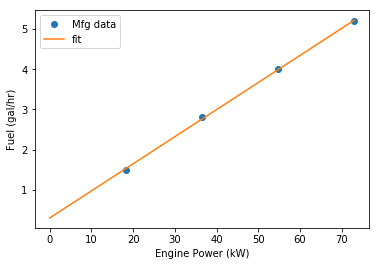

In [21]:
Aux1 = {}
Aux1['Capacity_kW'] = 65
Aux1['Fuel_gal_hr'] = np.array([1.5, 2.8, 4.0, 5.2])
# Note: According to the doc, the engine is rated to 73 kW, although the generator on
# board is rated to 65 kW. The 73 kW engine rating is used here. The generator load 
# should be divided by an efficiency of 65/73 to get the engine load.
ratedpower = 73 # kW
Aux1['gen_eff'] = 65/73
Aux1['Power_kW'] = ratedpower * np.array([0.25, 0.5, 0.75, 1.0])
Aux1['bsfc_coeffs'] = np.polyfit(Aux1['Power_kW'], Aux1['Fuel_gal_hr'], 1)
powertest = np.linspace(0, ratedpower, 100)
fueltest = Aux1['bsfc_coeffs'][0]*powertest + Aux1['bsfc_coeffs'][1]
plt.plot(Aux1['Power_kW'], Aux1['Fuel_gal_hr'], 'o', label='Mfg data')
plt.plot(powertest, fueltest, label='fit')
plt.ylabel('Fuel (gal/hr)')
plt.xlabel('Engine Power (kW)')
plt.legend(loc='best')

The second auxiliary generator has the same engine (John Deere 4045TFM75), but the generator is rated to 100 kW rather than 65 kW. Data sheets for the 4045TFM75 reveals that the engine is rated to 80 kW under M1 conditions (operating over 3000 hours per year and load factors over 65%) and to 101 kW under M3 conditions (up to 2000 hours per year, and load factors under 50%). Since the both auxiliary generators use the same engine, the same fuel consumption curve is used for each.

In [18]:
Aux2 = copy.copy(Aux1)
Aux2['Capacity_kW'] = 100

## Fuel consumption calculation
There are three modes considered here:
1.) Filling the tanks with water
2.) Pulling the hold down to temperature
3.) Maintaining hold temperature

### Filling tanks

In [34]:
load_kw = n_circ_pump * circ_pump_cap / Aux1['gen_eff']
load_kw_vfd = load_kw / vfd_eff
fuel_a = Aux1['bsfc_coeffs'][0]
fuel_b = Aux1['bsfc_coeffs'][1]
filling_fuel = (fuel_a*load_kw + fuel_b) * hrs_filling_tanks
filling_fuel_vfd = (fuel_a*load_kw_vfd + fuel_b) * hrs_filling_tanks
print("Fuel used to fill fish holds (gal): ", filling_fuel)
print("Fuel used to fill fish holds w/ vfd (gal): ", filling_fuel_vfd)
print('Total season hours to fill and empty tanks: ', hrs_filling_tanks)
print('Calculated engine load (kW): ', load_kw)
print('Fuel consumption rate with both circ pumps running at capacity (gal/hr): ', fuel_a*load_kw + fuel_b)

Fuel used to fill fish holds (gal):  85.1071716923
Fuel used to fill fish holds w/ vfd (gal):  86.389767033
Total season hours to fill and empty tanks:  74.2
Calculated engine load (kW):  12.567230769230768
Fuel consumption rate with both circ pumps running at capacity (gal/hr):  1.14699692308


### Pulling down hold
The following function will be used repeatedly to estimate fuel consumption per hold pull down. The function takes the hold capacity and compressor properties as inputs and calculates time to cool the hold and fuel required to cool the hold. The sea temperature, target temperature and engine properties defined above are also used by the function, but they are not passed to the function as input arguments; instead, they simply reference the values defined in earlier code cells.

In [31]:
def pulldown_calculator(water_vol, comp_sst, comp_power, comp_cap, other_loads, 
                        heat_load):
    """ A function for calculating consumption of a compressor during pull down
    :param water_vol: volume of water to be cooled (gallons)
    :param comp_sst: array of saturated suction temperatures associated 
        with compressor data (F)
    :param comp_power: array of compressor power requirements associated 
        with the listed SSTs (kW)
    :param comp_cap: array of compressor capacities associated with the 
        listed SSTs (btu/hr)
    :param other_loads: non-compressor loads on the generator (kW)
    :param heat_load: heat entering the hold (primarily circ pump) (btu/hr)
    :return time: time to pull down hold (hrs)
    :return fuel: fuel burned during pull down (gallon)
    """
    
    btus_removed = water_vol * water_heat_cap * (sea_temp - target_temp)
    if len(comp_sst) > 1:
        delta_sst = comp_sst[0] - comp_sst[1]
        btu_per_sst = btus_removed/(delta_sst * len(comp_sst))
    else:
        btu_per_sst = btus_removed
        delta_sst = 1
    times = btu_per_sst * delta_sst / (comp_cap - heat_load)
    fuel_a = Aux1['bsfc_coeffs'][0]
    fuel_b = Aux1['bsfc_coeffs'][1]
    fuel = sum((fuel_a * (comp_power+other_loads)/Aux1['gen_eff'] + fuel_b)*times)
    time = sum(times)
    return time, fuel

#### Salmon season: Aft holds only

This section calculates the fuel consumed during to pump down the two aft holds during the salmon season. It uses the function defined above to calculate fuel consumption per pump down cycle, then multiplies by the number of cycles.

In [37]:
b_time, b_fuel = pulldown_calculator(aft_tank_capacity, bitzer_sst, 
                bitzer_power, bitzer_capacity, other_loads, heat_load_basic)
b_salmon_pumpdown_fuel = b_fuel * n_aft_tank_pulldown
f_time, f_fuel = pulldown_calculator(aft_tank_capacity, frascold_sst, 
            frascold_power, frascold_capacity, other_loads, heat_load_basic)
f_salmon_pumpdown_fuel = f_fuel * n_aft_tank_pulldown
bv_time, bv_fuel = pulldown_calculator(aft_tank_capacity, bitzer_sst, 
                bitzer_power, bitzer_capacity, other_loads_vfd, heat_load_vfd)
bv_salmon_pumpdown_fuel = bv_fuel * n_aft_tank_pulldown
fv_time, fv_fuel = pulldown_calculator(aft_tank_capacity, frascold_sst, 
            frascold_power, frascold_capacity, other_loads_vfd, heat_load_vfd)
fv_salmon_pumpdown_fuel = fv_fuel * n_aft_tank_pulldown
print("time to pull down both aft holds once with Bitzer and VFD (hrs): ", bv_time)
print("time to pull down hold per salmon season with Bitzer and VFD (hrs): ", 
      bv_time*n_aft_tank_pulldown)
print("Fuel used to pump down holds during salmon season with Bitzer and VFD (gal): ",
      bv_salmon_pumpdown_fuel)
print("Fuel used to pump down holds during salmon season with Bitzer and no VFD (gal): ",
      b_salmon_pumpdown_fuel)
print("time to pull down both aft holds once with Frascold and vfd (hrs): ", fv_time)
print("time to pull down hold per salmon season with Frascold (hrs): ", 
      fv_time*n_aft_tank_pulldown)
print("Fuel used to pump down holds during salmon season with Frascold and vfd (gal): ", 
      fv_salmon_pumpdown_fuel)
print("Fuel used to pump down holds during salmon season with Frascold and no vfd (gal): ", 
      f_salmon_pumpdown_fuel)

time to pull down both aft holds once with Bitzer and VFD (hrs):  8.92175916586
time to pull down hold per salmon season with Bitzer and VFD (hrs):  294.418052473
Fuel used to pump down holds during salmon season with Bitzer and VFD (gal):  831.053681078
Fuel used to pump down holds during salmon season with Bitzer and no VFD (gal):  1130.04769545
time to pull down both aft holds once with Frascold and vfd (hrs):  10.9161411461
time to pull down hold per salmon season with Frascold (hrs):  360.23265782
Fuel used to pump down holds during salmon season with Frascold and vfd (gal):  1230.29924841
Fuel used to pump down holds during salmon season with Frascold and no vfd (gal):  1637.98997132


#### Herring season: all holds

This section does the same calculation as above, but for the herring season instead of the salmon season. The herring season has a different volume of water to cool and only one pull down cycle instead of 33.

In [40]:
other_loads = noncomp_loads(False)
heat_load_basic = heat_load(circ_vfd_ratio = 1)
tank_cap = aft_tank_capacity + forward_tank_capacity
b_time, b_fuel = pulldown_calculator(tank_cap, bitzer_sst, bitzer_power, 
                    bitzer_capacity, other_loads_basic, heat_load_basic)
b_herring_pumpdown_fuel = b_fuel * n_all_tank_pulldown
f_time, f_fuel = pulldown_calculator(tank_cap, frascold_sst, frascold_power, 
                    frascold_capacity, other_loads_basic, heat_load_basic)
f_herring_pumpdown_fuel = f_fuel * n_all_tank_pulldown
other_loads = noncomp_loads(True, circ_vfd_ratio = circ_sp)
heat_load_basic = heat_load(circ_vfd_ratio = circ_sp)
bv_time, bv_fuel = pulldown_calculator(tank_cap, bitzer_sst, bitzer_power, 
                    bitzer_capacity, other_loads_vfd, heat_load_vfd)
bv_herring_pumpdown_fuel = bv_fuel * n_all_tank_pulldown
fv_time, fv_fuel = pulldown_calculator(tank_cap, frascold_sst, frascold_power, 
                            frascold_capacity, other_loads_vfd, heat_load_vfd)
fv_herring_pumpdown_fuel = fv_fuel * n_all_tank_pulldown
print("time to pull down both aft holds once with Bitzer and VFD (hrs): ", bv_time)
print("time to pull down hold per herring season with Bitzer and VFD (hrs): ", 
      bv_time*n_aft_tank_pulldown)
print("Fuel used to pump down holds during herring season with Bitzer and VFD (gal): ",
      bv_herring_pumpdown_fuel)
print("Fuel used to pump down holds during herring season with Bitzer and no VFD (gal): ",
      b_herring_pumpdown_fuel)
print("time to pull down both aft holds once with Frascold and vfd (hrs): ", fv_time)
print("time to pull down hold per herring season with Frascold (hrs): ", 
      fv_time*n_aft_tank_pulldown)
print("Fuel used to pump down holds during herring season with Frascold and vfd (gal): ", 
      fv_herring_pumpdown_fuel)
print("Fuel used to pump down holds during herring season with Frascold and no vfd (gal): ", 
      f_herring_pumpdown_fuel)

time to pull down both aft holds once with Bitzer and VFD (hrs):  15.7846508319
time to pull down hold per herring season with Bitzer and VFD (hrs):  520.893477453
Fuel used to pump down holds during herring season with Bitzer and VFD (gal):  44.555325559
Fuel used to pump down holds during herring season with Bitzer and no VFD (gal):  60.5853076816
time to pull down both aft holds once with Frascold and vfd (hrs):  19.3131727969
time to pull down hold per herring season with Frascold (hrs):  637.334702298
Fuel used to pump down holds during herring season with Frascold and vfd (gal):  65.9600995651
Fuel used to pump down holds during herring season with Frascold and no vfd (gal):  87.8176441501


### Maintaining temp

There are two subsections here: cooling off fish, and maintaining the hold independently of the fish. The fuel used to cool fish is calculated by assuming that the compressor is operating at conditions when the hold is cold-an SST of 24 degrees. The time to pump out the btus in the fish is calculated at that condition (assuming that the fish have the same heat capacity as water on a mass basis). This time is then subtracted from the total freezer run time to get the time required to simply maintain temperature.

The temperature maintenance fuel demand is calculated by assuming that the compressor will run continuously at its minimum speed. The compressor power is then used to calculate the fuel consumption rate.

In [44]:
total_maintenance_hrs = 48
b_fish_hours = lbs_fish_cooled * (sea_temp-target_temp) * 1 / \
    (bitzer_capacity[-1]-heat_load_basic)
bv_fish_hours = lbs_fish_cooled * (sea_temp-target_temp) * 1 / \
    (bitzer_capacity[-1]-heat_load_vfd)
# if the calculated fish_hours is greater than the total_maintenance_hrs, 
# it implies that the hold is not always cooled back to the 
# target temperature before fish are delivered.
b_fish_hours = min(b_fish_hours, total_maintenance_hrs)
bv_fish_hours = min(bv_fish_hours, total_maintenance_hrs)
b_fish_cooling_fuel = b_fish_hours * (fuel_a * (bitzer_power[-1] + other_loads_basic) / 
                                  Aux1['gen_eff'] + fuel_b)
bv_fish_cooling_fuel = bv_fish_hours * (fuel_a * (bitzer_power[-1] + other_loads_vfd) / 
                                  Aux1['gen_eff'] + fuel_b)
f_fish_hours = lbs_fish_cooled * (sea_temp-target_temp) * 1 / \
    (frascold_capacity[-1]-heat_load_basic)
fv_fish_hours = lbs_fish_cooled * (sea_temp-target_temp) * 1 / \
    (frascold_capacity[-1]-heat_load_vfd)
# if the calculated fish_hours is greater than the total_maintenance_hrs, 
# it implies that the hold is not always cooled back to the target temperature 
# before fish are delivered.
f_fish_hours = min(f_fish_hours, total_maintenance_hrs)
fv_fish_hours = min(fv_fish_hours, total_maintenance_hrs)
f_fish_cooling_fuel = f_fish_hours * (fuel_a * (frascold_power[-1] + \
            other_loads_basic) / Aux1['gen_eff'] + fuel_b)
fv_fish_cooling_fuel = fv_fish_hours * (fuel_a * (frascold_power[-1] + \
            other_loads_vfd) / Aux1['gen_eff'] + fuel_b)
print("Fuel used to cool fish on board with Bitzer and vfd (gal): ", bv_fish_cooling_fuel)
print("Fuel used to cool fish on board with Bitzer and no vfd (gal): ", b_fish_cooling_fuel)
print("Fuel used to cool fish on board with Frascold and vfd (gal): ", fv_fish_cooling_fuel)
print("Fuel used to cool fish on board with Frascold (gal) and no vfd: ", f_fish_cooling_fuel)

Fuel used to cool fish on board with Bitzer and vfd (gal):  133.05149237
Fuel used to cool fish on board with Bitzer and no vfd (gal):  168.521649231
Fuel used to cool fish on board with Frascold and vfd (gal):  163.933953909
Fuel used to cool fish on board with Frascold (gal) and no vfd:  199.404110769


In [55]:
b_total_fuel = b_fish_cooling_fuel + b_herring_pumpdown_fuel + \
    b_salmon_pumpdown_fuel + filling_fuel
f_total_fuel = f_fish_cooling_fuel + f_herring_pumpdown_fuel + \
    f_salmon_pumpdown_fuel + filling_fuel
bv_total_fuel = bv_fish_cooling_fuel + bv_herring_pumpdown_fuel + \
    bv_salmon_pumpdown_fuel + filling_fuel_vfd
fv_total_fuel = fv_fish_cooling_fuel + fv_herring_pumpdown_fuel + \
    fv_salmon_pumpdown_fuel + filling_fuel_vfd
print("Total fuel used with the new Bitzer system and no vfd (gal): ", '{:4.1f}'.format(b_total_fuel))
print("Total fuel used with the new Bitzer system and vfd (gal): ", '{:4.1f}'.format(bv_total_fuel))
print("Total fuel used with the new Frascold system and no vfd (gal): ", '{:4.1f}'.format(f_total_fuel))
print("Total fuel used with the new Frascold system and vfd (gal): ", '{:4.1f}'.format(fv_total_fuel))

Total fuel used with the new Bitzer system and no vfd (gal):  1444.3
Total fuel used with the new Bitzer system and vfd (gal):  1095.1
Total fuel used with the new Frascold system and no vfd (gal):  2010.3
Total fuel used with the new Frascold system and vfd (gal):  1546.6


## Old system estimate

I haven't been able to find data relating sst to compressor capacity for the old system. To get a rough estimate, I simply assume that the compressor motor runs constantly at the assumed load factor.

In [16]:
old_comp_total_kw = (motor_power * motor_load_factor + circ_pump_cap * n_circ_pump 
                     + condenser_pump_cap + compressor_cool_pump)/Aux1['gen_eff']
old_total_fuel = total_time * (fuel_a * old_comp_total_kw + fuel_b) + filling_fuel
print("Total fuel used with the old system: ", old_total_fuel)

Total fuel used with the old system:  1546.00510745


In [14]:
btus_removed = aft_tank_capacity * water_heat_cap * (sea_temp - target_temp)
capacity = btus_removed/aft_pump_down_time
avg_cop = capacity / system_eff * joule_per_btu / sec_per_hr / watt_per_kW / (motor_power * motor_load_factor)
print('Average COP is ', avg_cop)

Average COP is  5.906752818874877


## Summary

The old system was estimated at 1546 gal/yr, while the new system was estimated at 1092 gal/yr with the Bitzer system and 1544 gal/yr with the Frascold system. The Bitzer system is uses less fuel because the manufacturer data for the Bitzer system lists a much higher COP than the Frascold system. However, there are several problems with these estimates:

1.) The average load factor for the compressor motor in the old system is unknown. The assumed value introduces a large source of error.

2.) The heating load only accounts for heat from the circ pumps; no heat infiltration through the hold insulation was included.

3.) The system efficiency has not been measured, so there is little evidence to support the value chosen.

In [56]:
fuel_a + fuel_b/12

0.092397260273972534

In [58]:
(fuel_a * 12 + fuel_b)/(12/.746)*31

0.068928356164383517